# HDFC Lead Prediction - End to End ML Pipeline

## Overview
This notebook covers the entire machine learning pipeline for the HDFC Lead Prediction dataset. 
The goal is to predict the `conversion_flag` based on various customer and lead attributes.

## Steps Covered:
1. Data Loading
2. Data Cleaning
3. Exploratory Data Analysis (EDA)
4. Feature Engineering & Preprocessing
5. Feature Selection
6. Model Building (6 Major Models)
7. Hyperparameter Tuning
8. Model Evaluation & Comparison
9. Saving the Final Model

**Note**: Each step is encapsulated in functions for modularity and reusability.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

## 1. Data Loading

In [2]:
def load_data(filepath):
    """
    Loads the dataset from a CSV file.
    """
    try:
        df = pd.read_csv(filepath)
        print(f"Data loaded successfully. Shape: {df.shape}")
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

# Usage
filepath = 'HDFC_Lead_Prediction_120k.csv'
df = load_data(filepath)
df.head()

Data loaded successfully. Shape: (120000, 47)


,customer_id,first_name,last_name,gender,age,date_of_birth,marital_status,dependents_count,education_level,occupation,annual_income,city,pincode,mobile_number,email,preferred_language,contact_channel_preference,mobile_app_usage,netbanking_active,last_login_date,avg_monthly_app_visits,credit_card_spend_last_6m,website_lead_source,lead_id,lead_creation_date,product_category,sub_product,lead_source,campaign_name,cibil_score,credit_utilization_ratio,existing_loans_count,existing_monthly_emi,avg_monthly_balance,account_tenure_years,lead_stage,lead_status_reason,assigned_rm_name,followup_count,last_followup_date,expected_conversion_probability,conversion_flag,conversion_date,revenue_generated,data_year,created_timestamp,updated_timestamp
0,CUST100000,Imaran,Taneja,M,25,1986-08-28,Single,0,Post Graduate,Self-Employed,4348668,OMR,668463,913124969502,pandeyjatin@example.org,English,Email,NaN,Yes,2025-02-03,33,956520,Google Ads,LEAD100000,2021-05-31,Credit Card,Business Regalia,Facebook Ads,HL_Sale_2025,834,63,2,28325,82930,4.1,Proposal,Not Interested,RM_Priya,2,2024-12-11,0.51,0,NaN,0,2022,2022-12-10 05:13:01.201706,2023-09-25 14:37:46.702238
1,CUST100001,Advika,Ahluwalia,F,41,1999-09-21,Married,1,12th,Business,1712858,T Nagar,960035,2903703796,edewan@example.com,Tamil,SMS,Medium,No,2025-11-29,49,492935,Organic,LEAD100001,2022-08-28,Personal Loan,PL-Self-Employed,Branch Walk-in,HL_Sale_2025,833,74,3,86828,155972,4.2,Qualified,Not Interested,RM_Deepa,11,2024-12-30,0.48,1,NaN,71887,2024,2021-06-11 08:43:57.593497,2021-08-10 19:59:03.691222
2,CUST100002,Yatan,Rege,F,62,1961-01-07,Single,2,12th,Business,1331261,Chennai,605283,9936107648,tripathidipta@example.net,English,WhatsApp,Medium,Yes,2024-12-08,27,509746,Referral,LEAD100002,2024-06-03,Personal Loan,PL-Salaried,Call Center,Monsoon2023,411,44,1,91835,108920,9.0,Lost,Already Purchased,RM_Sanjay,14,2025-04-30,0.44,0,NaN,0,2025,2025-10-05 12:29:31.057958,2021-10-14 02:29:24.816885
3,CUST100003,Bishakha,Salvi,M,68,1997-11-15,Married,4,Diploma,Business,3029029,Chennai,484242,7392638850,prashadxavier@example.org,Tamil,WhatsApp,Low,Yes,2024-06-30,10,169976,Referral,LEAD100003,2022-10-08,Savings Account,Imperial,Digital,HL_Sale_2025,872,27,3,59594,5420,6.0,Converted,No Response,RM_Arun,14,2025-02-26,0.91,0,NaN,0,2025,2022-01-03 18:24:58.991431,2021-09-07 14:18:34.396800
4,CUST100004,Henry,Gupta,F,54,1977-06-05,Single,4,Graduate,Self-Employed,3600442,OMR,699080,9362588189,anjaliupadhyay@example.org,English,SMS,NaN,Yes,2025-05-22,57,138928,Referral,LEAD100004,2022-02-13,Credit Card,Business Regalia,RM Referral,Diwali2024,679,14,4,37344,80766,13.3,Proposal,Low CIBIL,RM_Priya,15,2025-09-20,0.16,0,2025-06-04,0,2020,2022-11-23 06:04:34.328439,2022-08-13 02:29:08.153645


## 2. Data Cleaning

In [3]:
def clean_data(df):
    """
    Performs initial data cleaning: dropping IDs, PII, leakage columns, and handling duplicates.
    """
    df_clean = df.copy()
    
    # Drop duplicates
    initial_count = len(df_clean)
    df_clean.drop_duplicates(inplace=True)
    print(f"Dropped {initial_count - len(df_clean)} duplicate rows.")
    
    # Columns to drop (IDs, PII, Leakage)
    cols_to_drop = [
        'customer_id', 'first_name', 'last_name', 'mobile_number', 'email', 'lead_id',
        'conversion_date', 'revenue_generated', # Target leakage (future info)
        'lead_status_reason', 'lead_stage', # Highly correlated with target / post-event info
        'expected_conversion_probability', # Likely from another model
        'created_timestamp', 'updated_timestamp', 'assigned_rm_name' # Administrative
    ]
    
    # Drop columns if they exist
    existing_cols_to_drop = [col for col in cols_to_drop if col in df_clean.columns]
    df_clean.drop(columns=existing_cols_to_drop, inplace=True)
    print(f"Dropped columns: {existing_cols_to_drop}")
    
    # Handle missing values for categorical and numerical separately in preprocessing, 
    # but let's check for nulls here.
    print("\nMissing Values:")
    print(df_clean.isnull().sum()[df_clean.isnull().sum() > 0])
    
    return df_clean

# Usage
df_clean = clean_data(df)

Dropped 0 duplicate rows.
Dropped columns: ['customer_id', 'first_name', 'last_name', 'mobile_number', 'email', 'lead_id', 'conversion_date', 'revenue_generated', 'lead_status_reason', 'lead_stage', 'expected_conversion_probability', 'created_timestamp', 'updated_timestamp', 'assigned_rm_name']

Missing Values:
mobile_app_usage    30001
dtype: int64


## 3. Exploratory Data Analysis (EDA)

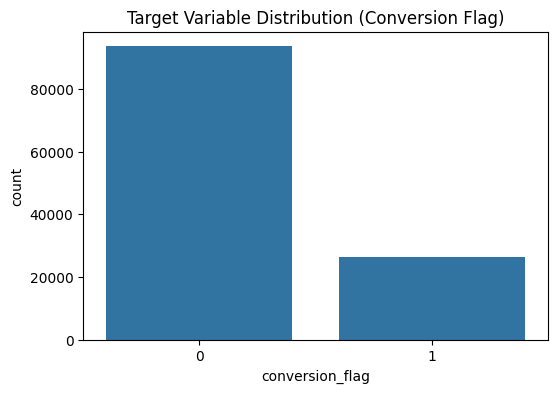

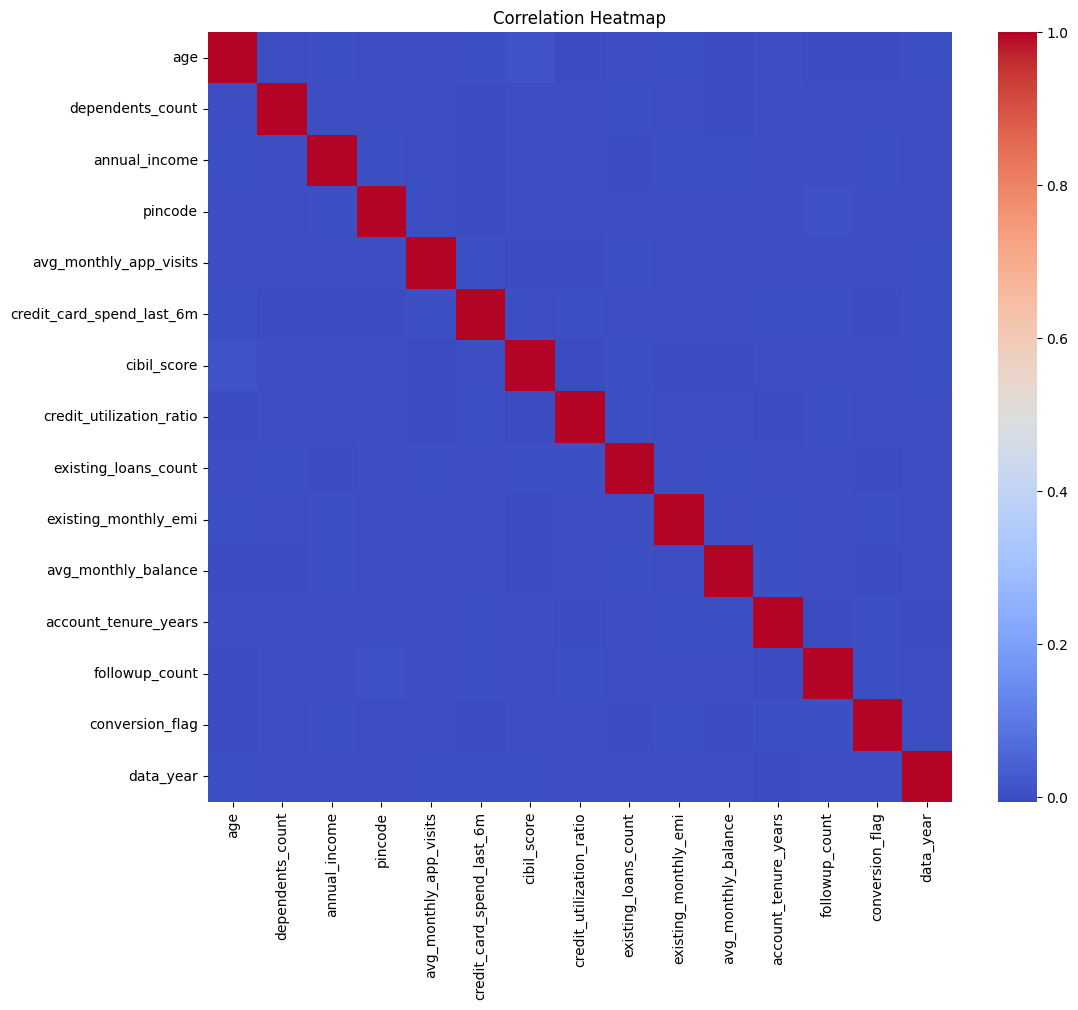

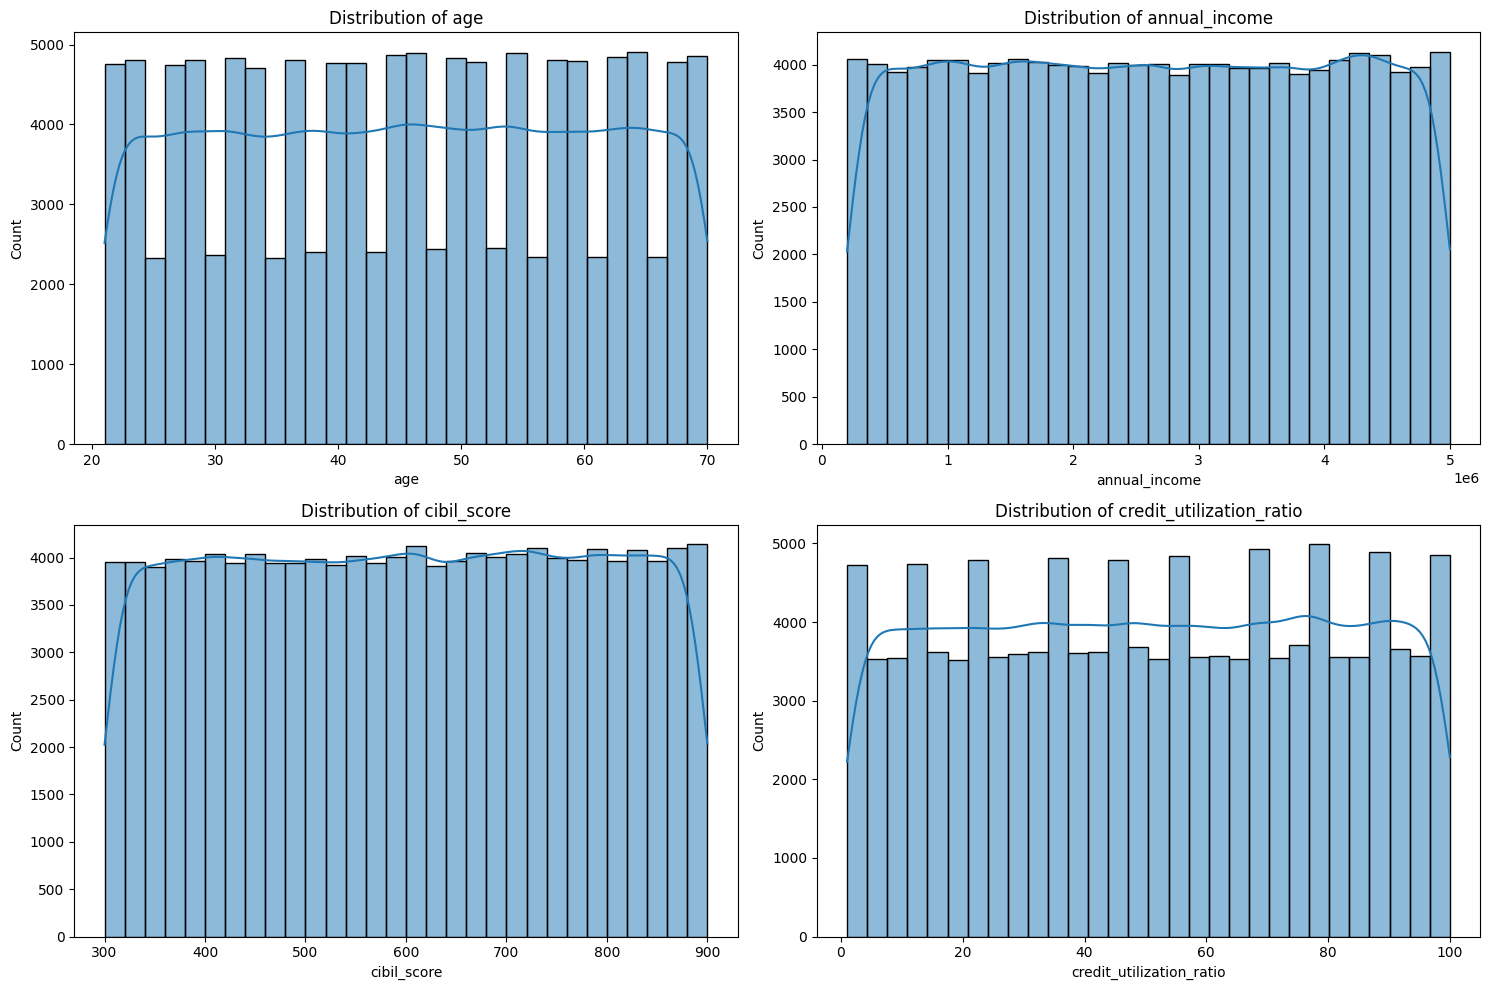

In [4]:
def perform_eda(df):
    """
    Performs basic Exploratory Data Analysis.
    """
    # Target Distribution
    plt.figure(figsize=(6, 4))
    sns.countplot(x='conversion_flag', data=df)
    plt.title('Target Variable Distribution (Conversion Flag)')
    plt.show()
    
    # Numerical Features Correlation
    plt.figure(figsize=(12, 10))
    numeric_df = df.select_dtypes(include=[np.number])
    sns.heatmap(numeric_df.corr(), annot=False, cmap='coolwarm')
    plt.title('Correlation Heatmap')
    plt.show()
    
    # Distribution of key numerical features
    num_cols = ['age', 'annual_income', 'cibil_score', 'credit_utilization_ratio']
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(num_cols):
        if col in df.columns:
            plt.subplot(2, 2, i+1)
            sns.histplot(df[col], kde=True, bins=30)
            plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()

# Usage
perform_eda(df_clean)

## 4. Feature Engineering & Preprocessing

In [5]:
def preprocess_features(df):
    """
    Handles preprocessing: Date conversion, Encoding, Scaling.
    Returns X_train, X_test, y_train, y_test and the preprocessor object.
    """
    df_proc = df.copy()
    
    # Date Feature Engineering
    date_cols = ['date_of_birth', 'last_login_date', 'lead_creation_date', 'last_followup_date']
    for col in date_cols:
        if col in df_proc.columns:
            df_proc[col] = pd.to_datetime(df_proc[col], errors='coerce')
            # Extract useful parts or calculate duration (e.g., age from DOB is already there, maybe lead age)
            # For simplicity, we might drop original dates after extracting info, or just drop them if not critical
            # Let's extract Month and Year for lead_creation
            if col == 'lead_creation_date':
                df_proc['lead_month'] = df_proc[col].dt.month
                df_proc['lead_year'] = df_proc[col].dt.year
                df_proc['lead_day_of_week'] = df_proc[col].dt.dayofweek
            
            df_proc.drop(columns=[col], inplace=True)
            
    # Separate Target and Features
    X = df_proc.drop(columns=['conversion_flag'])
    y = df_proc['conversion_flag']
    
    # Identify Categorical and Numerical columns
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns
    numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
    
    print(f"Categorical Columns: {list(categorical_cols)}")
    print(f"Numerical Columns: {list(numerical_cols)}")
    
    # Define Preprocessing Pipelines
    num_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    cat_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_pipeline, numerical_cols),
            ('cat', cat_pipeline, categorical_cols)
        ]
    )
    
    # Split Data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Fit and Transform
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)
    
    # Get feature names after OneHotEncoding
    # This can be tricky with ColumnTransformer, but useful for feature importance
    try:
        cat_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols)
        feature_names = list(numerical_cols) + list(cat_feature_names)
    except:
        feature_names = None
        
    print("Preprocessing complete.")
    return X_train_processed, X_test_processed, y_train, y_test, preprocessor, feature_names

# Usage
X_train, X_test, y_train, y_test, preprocessor, feature_names = preprocess_features(df_clean)

Categorical Columns: ['gender', 'marital_status', 'education_level', 'occupation', 'city', 'preferred_language', 'contact_channel_preference', 'mobile_app_usage', 'netbanking_active', 'website_lead_source', 'product_category', 'sub_product', 'lead_source', 'campaign_name']
Numerical Columns: ['age', 'dependents_count', 'annual_income', 'pincode', 'avg_monthly_app_visits', 'credit_card_spend_last_6m', 'cibil_score', 'credit_utilization_ratio', 'existing_loans_count', 'existing_monthly_emi', 'avg_monthly_balance', 'account_tenure_years', 'followup_count', 'data_year']
Preprocessing complete.


## 5. Feature Selection

In [6]:
def select_features(X_train, y_train, feature_names, k=20):
    """
    Selects top k features using SelectKBest with ANOVA F-value.
    """
    selector = SelectKBest(score_func=f_classif, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    
    if feature_names:
        selected_indices = selector.get_support(indices=True)
        selected_features = [feature_names[i] for i in selected_indices]
        print(f"Top {k} Selected Features: {selected_features}")
    else:
        print(f"Top {k} features selected (names unavailable).")
        
    return X_train_selected, selector

# Usage
# Note: We will use the full features for model building to let models decide, 
# but this function demonstrates feature selection capability.
# X_train_sel, selector = select_features(X_train, y_train, feature_names)

## 6. Model Building (6 Major Models)

In [7]:
def build_and_evaluate_models(X_train, X_test, y_train, y_test):
    """
    Trains and evaluates 6 major classification models.
    """
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        'K-Nearest Neighbors': KNeighborsClassifier()
    }
    
    results = []
    
    for name, model in models.items():
        print(f"Training {name}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
        
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_prob) if y_prob is not None else 0
        
        results.append({
            'Model': name,
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec,
            'F1 Score': f1,
            'AUC-ROC': auc
        })
        
    results_df = pd.DataFrame(results)
    return results_df, models

# Usage
results_df, trained_models = build_and_evaluate_models(X_train, X_test, y_train, y_test)
print(results_df)

Training Logistic Regression...
Training Decision Tree...
Training Random Forest...
Training Gradient Boosting...
Training XGBoost...
Training K-Nearest Neighbors...
                 Model  Accuracy  Precision    Recall  F1 Score   AUC-ROC
0  Logistic Regression  0.780000   0.000000  0.000000  0.000000  0.496269
1        Decision Tree  0.644625   0.225823  0.253409  0.238822  0.504189
2        Random Forest  0.780000   0.000000  0.000000  0.000000  0.506112
3    Gradient Boosting  0.779792   0.000000  0.000000  0.000000  0.499332
4              XGBoost  0.777333   0.209091  0.004356  0.008534  0.494924
5  K-Nearest Neighbors  0.742417   0.228640  0.071970  0.109479  0.502240


## 7. Hyperparameter Tuning

In [8]:
def tune_hyperparameters(X_train, y_train):
    """
    Performs hyperparameter tuning for the best model (e.g., Random Forest or XGBoost).
    Here we demonstrate with Random Forest.
    """
    print("Tuning Random Forest...")
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }
    
    rf = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, scoring='f1', verbose=1)
    grid_search.fit(X_train, y_train)
    
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Best F1 Score: {grid_search.best_score_}")
    
    return grid_search.best_estimator_

# Usage
best_model = tune_hyperparameters(X_train, y_train)

Tuning Random Forest...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best F1 Score: 0.0


## 8. Model Evaluation & Comparison

Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88     18720
           1       0.00      0.00      0.00      5280

    accuracy                           0.78     24000
   macro avg       0.39      0.50      0.44     24000
weighted avg       0.61      0.78      0.68     24000



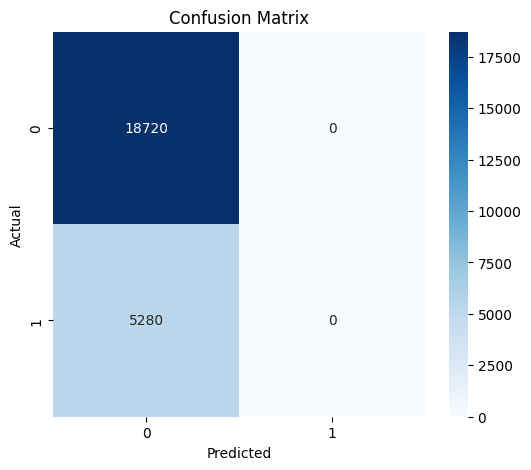

In [9]:
def evaluate_final_model(model, X_test, y_test):
    """
    Detailed evaluation of the final tuned model.
    """
    y_pred = model.predict(X_test)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Usage
evaluate_final_model(best_model, X_test, y_test)

## 9. Saving Final Model

In [10]:
def save_model(model, preprocessor, filename='final_model_pipeline.pkl'):
    """
    Saves the model and preprocessor as a pipeline.
    """
    full_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    joblib.dump(full_pipeline, filename)
    print(f"Model pipeline saved to {filename}")

# Usage
save_model(best_model, preprocessor)

Model pipeline saved to final_model_pipeline.pkl
